# Setup

In [1]:
try:
  import rtree
except ModuleNotFoundError as e:
  if (platform.system() == 'Linux'):
    !apt-get install libspatialindex-dev
    !pip install rtree==0.9.7
    import rtree

if rtree.__version__ != "0.9.7":
  !pip install -U rtree==0.9.7
  import rtree

In [ ]:
try:
  import movingpandas as mpd
except ModuleNotFoundError as e:
  !pip install movingpandas==0.7.rc1
  import movingpandas as mpd

if mpd.__version__ != "0.7.rc1":
  !pip install -U movingpandas==0.7.rc1

In [3]:
try:
  import pyrosm
except ModuleNotFoundError as e:
  !pip install pyrosm==0.6.1
  import pyrosm


In [4]:
try:
  import geojson
except ModuleNotFoundError as e:
  !pip install geojson==2.5.0
  import geojson 
if geojson.__version__ != "2.5.0":
  !pip install -U geojson==2.5.0
  import geojson 

In [5]:
try:
  import osmnx  as ox
except ModuleNotFoundError as e:
  !pip install osmnx==1.1.1
  import osmnx  as ox
if ox.__version__ != "1.1.1":
  !pip install -U osmnx==1.1.1
  import osmnx  as ox

this tutorial include also the Fast Map Matching<Br/>
For this package you have to follow the instruction on the [official website](https://fmm-wiki.github.io/docs/installation/)

In [6]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

In [7]:
from shapely.geometry import Polygon
from shapely import wkt
import os
import numpy as np
import pyrosm
import osmnx as ox
import warnings
warnings.simplefilter("ignore")
from matplotlib import pyplot as plt

# Exercise

the [trips_truck.gpkg](https://github.com/napo/geospatial_course_unitn/raw/master/data/geotemporaldata/trips_truck.gpkg) dataset contains the routes of a garbage vehicle in April 2018.

Based on this data:
- identify the longest route carried out
- identify the places of the daily departure and arrival points
- show the km traveled day by day
- identify the breaks carried out in the shortest route of the third week and in the longest one of the last
- identify the longest route of the third week of the month on the OpenStreetMap road graph

## Download the data


In [8]:
truck = gpd.read_file("https://github.com/napo/geospatial_course_unitn/raw/master/data/geotemporaldata/trips_truck.gpkg")

In [9]:
truck.head(5)

,vehicleid,latitude,longitude,timestamp,geometry
0,8867,45.177197,11.057768,2018-04-01T00:00:27+00:00,POINT (11.05777 45.17720)
1,8867,45.177198,11.057855,2018-04-01T02:00:28+00:00,POINT (11.05785 45.17720)
2,8867,45.177232,11.057655,2018-04-01T02:04:13+00:00,POINT (11.05766 45.17723)
3,8867,45.177212,11.057705,2018-04-01T03:00:28+00:00,POINT (11.05771 45.17721)
4,8867,45.177278,11.057865,2018-04-01T04:00:28+00:00,POINT (11.05786 45.17728)


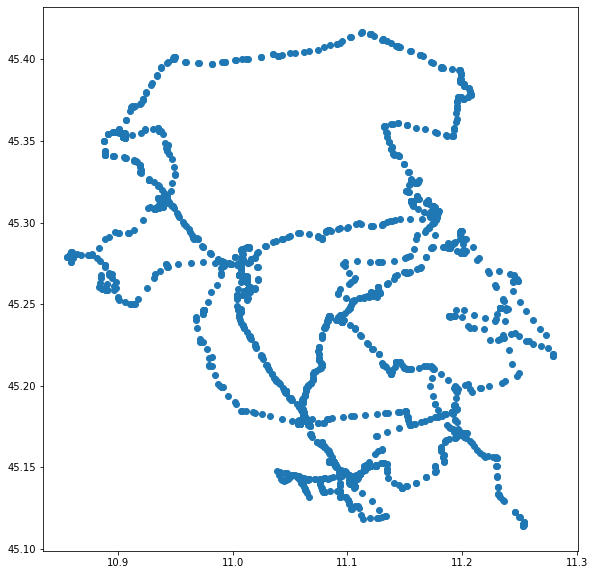

In [10]:
truck.plot(figsize=(10,10))
plt.show()

In [11]:
type(truck['timestamp'][0])

str

In [12]:
truck['timestamp'] = pd.to_datetime(truck['timestamp'], format='%Y-%m-%d %H:%M:%S')

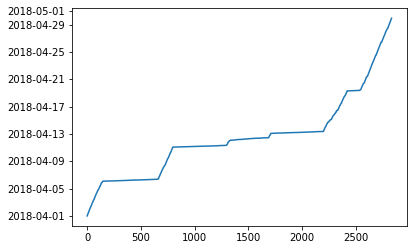

In [13]:
truck['timestamp'].plot()
plt.show()

In [14]:
truck['timestamp'].min()

Timestamp('2018-04-01 00:00:27+0000', tz='UTC')

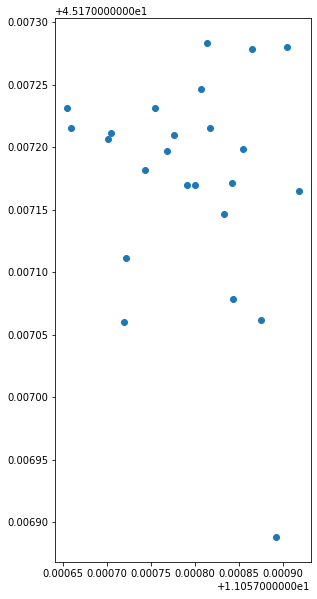

In [15]:
truck[(truck['timestamp'] >= '2018-04-01') & (truck['timestamp'] < '2018-04-02')].plot(figsize =(10,10))
plt.show()

In [16]:
truck['weekday'] = truck['timestamp'].apply(lambda x: x.weekday())

In [17]:
truck.weekday.unique()
# Monday == 0 … Sunday == 6

array([6, 0, 1, 2, 3, 4, 5])

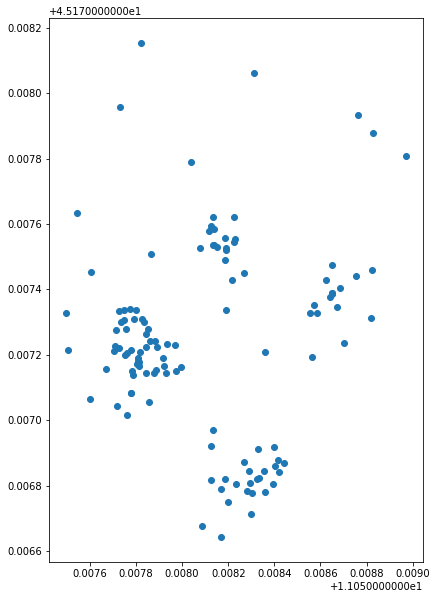

In [18]:
truck[truck.weekday == 0].plot(figsize=(10,10))
plt.show()

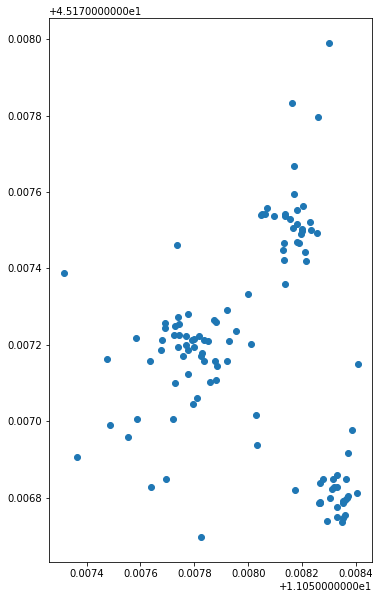

In [19]:
truck[truck.weekday == 1].plot(figsize =(10,10))
plt.show()

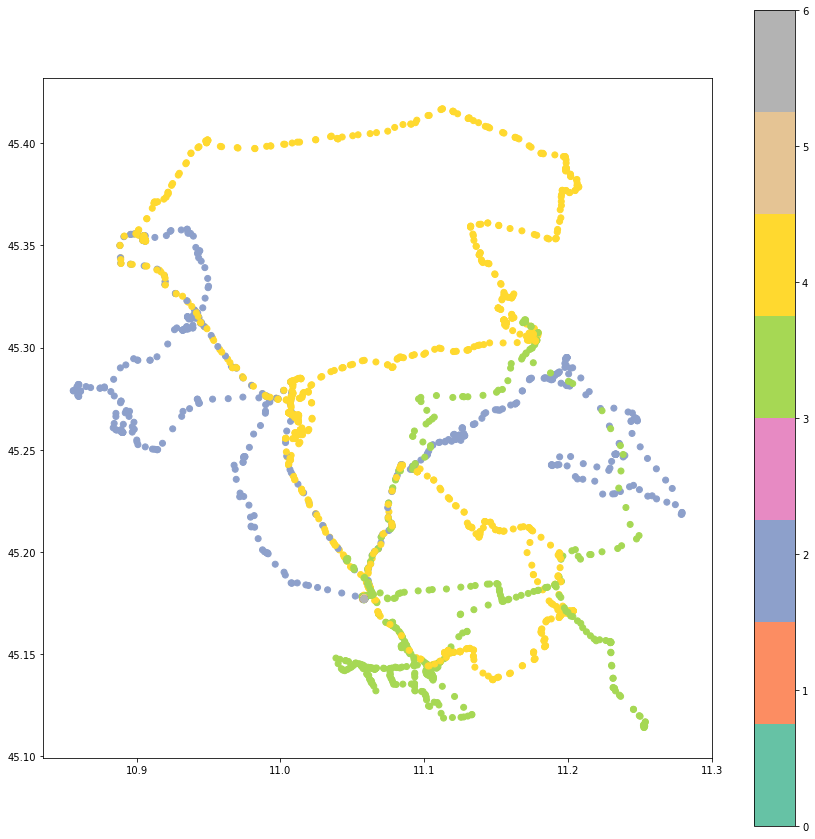

In [20]:
truck.plot(column='weekday', cmap="Set2", legend=True,figsize=(15,15))
plt.show()

In [21]:
truck['day'] = truck['timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))

## identify the longest route carried out
we need to create the trajectory day by day


In [22]:
# to use in movingpandas
truck = truck.set_index('timestamp').tz_localize(None)

In [23]:
# this trajectory contains all the points of the truck
trajectory = mpd.Trajectory(truck,"vehiclesid")


In [24]:
trajectory.add_speed()

In [25]:
trajectory.add_direction()

In [26]:
trajectory.df.head(5)

,vehicleid,latitude,longitude,geometry,weekday,day,speed,prev_pt,direction
timestamp,,,,,,,,,
2018-04-01 00:00:27,8867,45.177197,11.057768,POINT (11.05777 45.17720),6,2018-04-01,0.000946,None,88.437276
2018-04-01 02:00:28,8867,45.177198,11.057855,POINT (11.05785 45.17720),6,2018-04-01,0.000946,POINT (11.05777 45.17720),88.437276
2018-04-01 02:04:13,8867,45.177232,11.057655,POINT (11.05766 45.17723),6,2018-04-01,0.071783,POINT (11.05785 45.17720),283.302496
2018-04-01 03:00:28,8867,45.177212,11.057705,POINT (11.05771 45.17721),6,2018-04-01,0.001338,POINT (11.05766 45.17723),119.572435
2018-04-01 04:00:28,8867,45.177278,11.057865,POINT (11.05786 45.17728),6,2018-04-01,0.004055,POINT (11.05771 45.17721),59.413161


we need a collection of trajectories base on the timestamp of the vehicle


In [27]:
traj_collection = mpd.TrajectoryCollection(trajectory.to_point_gdf(), 'vehicleid',"timestamp¨")

and day by day

In [28]:
daily = mpd.TemporalSplitter(traj_collection).split(mode='day')

calculate the length of each path

In [29]:
daily_lengths = [traj.get_length() for traj in daily]

and add the starting day

In [30]:
daily_t = [traj.get_start_time() for traj in daily]

transform the daily_lenghts in a dataframe to obtain the max length 

In [31]:
rows = {}
rows['length'] =  daily_lengths
rows['day'] = daily_t
daily_lengths = pd.DataFrame(rows)

In [32]:
daily_lengths

,length,day
0,281.801011,2018-04-01 00:00:27
1,414.089055,2018-04-02 00:00:28
2,498.681155,2018-04-03 00:00:25
3,754.454242,2018-04-04 00:00:26
4,738.204809,2018-04-05 00:00:27
5,167779.977302,2018-04-06 00:00:29
6,700.033183,2018-04-07 00:00:25
7,640.248828,2018-04-08 00:00:28
8,479.058474,2018-04-09 00:00:27
9,594.202797,2018-04-10 00:00:27


In [33]:
day_with_the_longest_route = daily_lengths[daily_lengths.length == daily_lengths.length.max()]['day']

In [34]:
from_day = day_with_the_longest_route.values[0]
to_day = (day_with_the_longest_route+ pd.DateOffset(days=1)).values[0]


In [35]:
truck_trip_longest = truck.reset_index()[(truck.reset_index().timestamp >= from_day) & (truck.reset_index().timestamp < to_day)]

In [36]:
truck_trip_longest = truck_trip_longest.set_index('timestamp').tz_localize(None)


In [37]:
longest_trajectory = mpd.Trajectory(truck_trip_longest,"vehiclesid")


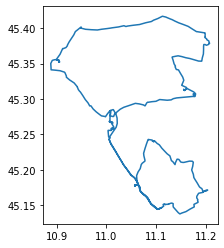

In [38]:
longest_trajectory.to_traj_gdf().plot()
plt.show()

In [39]:
longest_trajectory_plot = longest_trajectory.hvplot(title='Trajectory {}'.format(trajectory.id), line_width=7.0, tiles='CartoLight', color='blue', frame_width=350, frame_height=350) 
longest_trajectory_plot

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]

## identify the places of the daily departure and arrival points

In [40]:
from geopy.geocoders import ArcGIS
rows = []
geolocator = ArcGIS()  #user_agent="geospatial course")
for traj in daily:
    departure = traj.df['geometry'][0]
    latlon = str(departure.y) + "," + str(departure.x);
    location_departure = geolocator.reverse(latlon)
    arrival = traj.df['geometry'][-1]
    latlon = str(arrival.y) + "," + str(arrival.x);
    location_arrival = geolocator.reverse(latlon)
    day = traj.df.reset_index()['timestamp'][0]
    day = day.strftime("%Y-%m-%d")
    data = {}
    data['day'] = day
    data['arrival'] = arrival
    data['arrival_location'] = location_arrival.address
    data['departure'] = departure
    data['departure_location'] = location_arrival.address
    rows.append(data)

In [41]:
arrivals_depatures_days = pd.DataFrame(rows)

In [42]:
arrivals_depatures_days

,day,arrival,arrival_location,departure,departure_location
0,2018-04-01,POINT (11.0578 45.17717),", Nogara, Veneto 37054, ITA",POINT (11.0577683333333 45.1771966666667),", Nogara, Veneto 37054, ITA"
1,2018-04-02,POINT (11.057815 45.177165),", Nogara, Veneto 37054, ITA",POINT (11.057835 45.1773016666667),", Nogara, Veneto 37054, ITA"
2,2018-04-03,POINT (11.0577966666667 45.177045),", Nogara, Veneto 37054, ITA",POINT (11.057775 45.1771866666667),", Nogara, Veneto 37054, ITA"
3,2018-04-04,POINT (11.0577333333333 45.17718),", Nogara, Veneto 37054, ITA",POINT (11.0577733333333 45.1771683333333),", Nogara, Veneto 37054, ITA"
4,2018-04-05,POINT (11.0577266666667 45.1772566666667),"Via Francesco Stellini, Nogara, Veneto 37054, ITA",POINT (11.0578183333333 45.1771966666667),"Via Francesco Stellini, Nogara, Veneto 37054, ITA"
5,2018-04-06,POINT (11.0577516666667 45.17729),"Via Francesco Stellini, Nogara, Veneto 37054, ITA",POINT (11.0578783333333 45.1771616666667),"Via Francesco Stellini, Nogara, Veneto 37054, ITA"
6,2018-04-07,POINT (11.0577383333333 45.1773366666667),"Via Francesco Stellini, Nogara, Veneto 37054, ITA",POINT (11.0577666666667 45.1772283333333),"Via Francesco Stellini, Nogara, Veneto 37054, ITA"
7,2018-04-08,POINT (11.0576433333333 45.17716),", Nogara, Veneto 37054, ITA",POINT (11.0578716666667 45.1772016666667),", Nogara, Veneto 37054, ITA"
8,2018-04-09,POINT (11.0578283333333 45.1773083333333),"Via Francesco Stellini, Nogara, Veneto 37054, ITA",POINT (11.05789 45.177225),"Via Francesco Stellini, Nogara, Veneto 37054, ITA"
9,2018-04-10,POINT (11.05788 45.1772583333333),", Nogara, Veneto 37054, ITA",POINT (11.05769 45.1772566666667),", Nogara, Veneto 37054, ITA"


In [43]:
gdf_locations_arrivals = gpd.GeoDataFrame(arrivals_depatures_days,geometry="arrival",crs="epsg:4326")

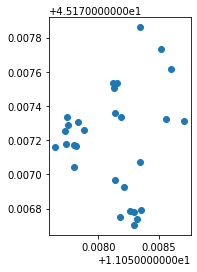

In [44]:
gdf_locations_arrivals.plot()
plt.show()

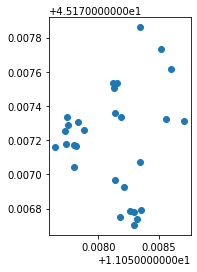

In [45]:
gdf_locations_departures = gpd.GeoDataFrame(arrivals_depatures_days,geometry="arrival",crs="epsg:4326")
gdf_locations_departures.plot()
plt.show()

## show the km traveled day by day

In [46]:
daily_lengths['length'] = daily_lengths['length'].apply(lambda x: round(x/100,2))
daily_lengths['day'] = daily_lengths['day'].apply(lambda x: x.strftime("%Y-%m-%d"))

In [47]:
daily_lengths = daily_lengths.set_index("day")

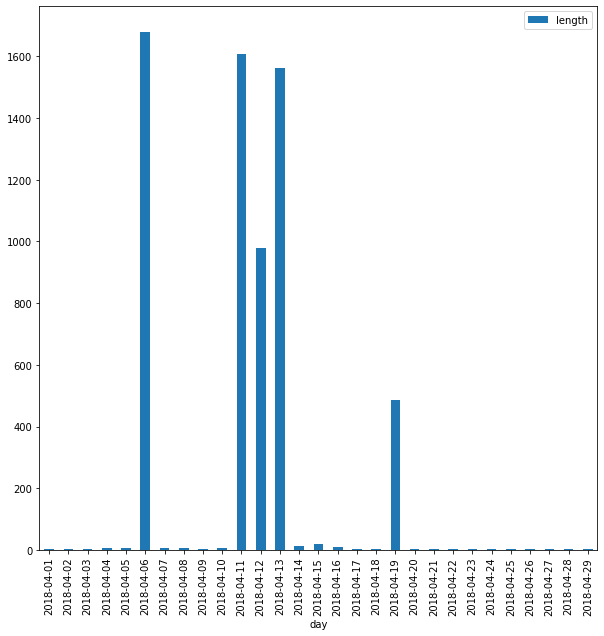

In [48]:
daily_lengths.plot(kind="bar",figsize=(10,10))
plt.show()

## identify the breaks carried out in the shortest route of the third week and in the longest one of the last
### identify the weeks

In [49]:
from datetime import datetime, timedelta

In [50]:
weeks_begin = truck[truck.weekday == 0].reset_index().sort_values("day")['day'].unique()

In [51]:
first_day_week3 = weeks_begin[2]

In [52]:
first_day_week4 = weeks_begin[3]

In [53]:
last_day_week3 = datetime.strptime(first_day_week3, "%Y-%m-%d") + timedelta(days=6)
last_day_week4 = datetime.strptime(first_day_week4, "%Y-%m-%d") + timedelta(days=6)

In [54]:
last_day_week4.strftime("%Y-%m-%d")

'2018-04-29'

### shortest route third week

In [55]:
truck_trips_third_week = truck.reset_index()[(truck.reset_index()['timestamp'] >= first_day_week3) & (truck.reset_index()['timestamp'] <= last_day_week3)]

In [56]:
truck_trips_third_week['timestamp'] = pd.to_datetime(truck_trips_third_week['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [57]:
truck_trips_third_week = truck_trips_third_week.set_index("timestamp")

In [58]:
# this trajectory contains all the points of the truck
trajectory_third_week = mpd.Trajectory(truck_trips_third_week,"vehiclesid")

In [59]:
traj_collection_third_week = mpd.TrajectoryCollection(trajectory_third_week.to_point_gdf(), 'vehicleid',"timestamp¨")

In [60]:
daily_third_week = mpd.TemporalSplitter(traj_collection_third_week).split(mode='day')

In [61]:
daily_lengths_third_week = [traj.get_length() for traj in daily_third_week]

In [62]:
min_lenght = min(daily_lengths_third_week)

In [63]:
idx_min_length = daily_lengths_third_week.index(min_lenght)

In [64]:
daily_days_third_week = [traj.get_start_time() for traj in daily_third_week]

In [65]:
day_shortest_route_third_week = daily_days_third_week[idx_min_length]
day_shortest = day_shortest_route_third_week.strftime("%Y-%m-%d")

In [66]:
print("the route of the %s is long %f km" % (day_shortest,round((min_lenght/1000),2)))


the route of the 2018-04-20 is long 0.320000 km


In [67]:
stops_third_week = mpd.TrajectoryStopDetector(trajectory_third_week)

In [68]:
seconds_pause = 120
max_diameter = min_lenght
stop_durations_third_week = stops_third_week.get_stop_time_ranges(min_duration=timedelta(seconds=seconds_pause), max_diameter=max_diameter)

In [69]:
stops_trajections = []
for stop_time in stop_durations_third_week: 
    time_stop = stop_time.t_0
    day_stop = time_stop.strftime("%Y-%m-%d")
    if day_stop == day_shortest:
       stops_trajections.append(stop_time)

In [70]:
for stops_trajection in stops_trajections:
    print(stops_trajection)

In [71]:
print("there are %i trajectory with breaks of %s seconds in the range of %i diameter" % (len(stops_trajections),seconds_pause,max_diameter))

there are 0 trajectory with breaks of 120 seconds in the range of 324 diameter


In [72]:
stop_points_third_week = stops_third_week.get_stop_points(min_duration=timedelta(seconds=seconds_pause), max_diameter=max_diameter)

In [73]:
stop_points_third_week

,geometry,start_time,end_time,traj_id,duration_s
stop_id,,,,,
vehiclesid_2018-04-16 00:00:30,POINT (11.05856 45.17733),2018-04-16 00:00:30,2018-04-19 07:34:16,vehiclesid,286426.0
vehiclesid_2018-04-19 07:39:47,POINT (11.04663 45.19661),2018-04-19 07:39:47,2018-04-19 07:46:18,vehiclesid,391.0
vehiclesid_2018-04-19 08:12:09,POINT (11.22977 45.15575),2018-04-19 08:12:09,2018-04-19 08:24:27,vehiclesid,738.0
vehiclesid_2018-04-19 08:31:59,POINT (11.25244 45.11512),2018-04-19 08:31:59,2018-04-19 08:44:12,vehiclesid,733.0
vehiclesid_2018-04-19 09:15:11,POINT (11.05724 45.17798),2018-04-19 09:15:11,2018-04-21 23:00:29,vehiclesid,222318.0


## breaks of longest route one the last week

In [74]:
truck_trips_last_week = truck.reset_index()[(truck.reset_index()['timestamp'] >= first_day_week4) & (truck.reset_index()['timestamp'] <= last_day_week4)]
truck_trips_last_week['timestamp'] = pd.to_datetime(truck_trips_last_week['timestamp'], format='%Y-%m-%d %H:%M:%S')
truck_trips_last_week = truck_trips_last_week.set_index("timestamp")
trajectory_last_week = mpd.Trajectory(truck_trips_last_week,"vehiclesid")
traj_collection_last_week = mpd.TrajectoryCollection(trajectory_last_week.to_point_gdf(), 'vehicleid',"timestamp¨")

In [75]:
daily_last_week = mpd.TemporalSplitter(traj_collection_last_week).split(mode='day')
daily_lengths_last_week = [traj.get_length() for traj in daily_last_week]
max_lenght = max(daily_lengths_last_week)
idx_max_lenght = daily_lengths_last_week.index(max_lenght)
daily_days_last_week = [traj.get_start_time() for traj in daily_last_week]
day_longest_route_last_week = daily_days_last_week[idx_max_lenght]
day_longest = day_longest_route_last_week.strftime("%Y-%m-%d")


In [76]:
print("the route of the %s is long %f km" % (day_longest,round((max_lenght/1000),2)))

the route of the 2018-04-28 is long 0.340000 km


In [77]:
stops_last_week = mpd.TrajectoryStopDetector(trajectory_last_week)

In [78]:
seconds_pause = 60
max_diameter = 30
stop_durations_last_week = stops_last_week.get_stop_time_ranges(min_duration=timedelta(seconds=seconds_pause), max_diameter=max_diameter)

In [79]:
stops_trajections = []
for stop_time in stop_durations_last_week: 
    time_stop = stop_time.t_0
    day_stop = time_stop.strftime("%Y-%m-%d")
    if day_stop == day_longest:
       stops_trajections.append(stop_time)

In [80]:
stops_trajections

In [81]:
stop_points = stops_last_week.get_stop_points(min_duration=timedelta(seconds=seconds_pause), max_diameter=max_diameter)

In [82]:
traj_plot = trajectory_last_week.hvplot(title='Trajectory {}'.format(trajectory_last_week.obj_id), line_width=7.0, tiles='CartoLight', color='slategray', frame_width=350, frame_height=350) 

In [83]:
stop_point_plot = traj_plot * stop_points.hvplot(geo=True, color='deeppink')
stop_point_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

## identify the longest route of the third week of the month on the OpenStreetMap road graph

for this operation we will use an algorithm of Map Matching.

![](https://fmm-wiki.github.io/assets/images/fmm.png)

Read the article [Fast map matching, an algorithm integrating hidden Markov model with precomputation](https://www.tandfonline.com/doi/full/10.1080/13658816.2017.1400548)

The method use is [Map-matching for low-sampling-rate GPS trajectories](https://dl.acm.org/doi/abs/10.1145/1653771.1653820)

Read the [documentation](https://fmm-wiki.github.io/) for the [installation](https://fmm-wiki.github.io/docs/installation/)

[Source code](https://github.com/cyang-kth/fmm)

### download of the OSM data 
Nogara is locate in Province of Verona - download the OSM raw data from [https://osmit-estratti.wmcloud.org]([https://osmit-estratti.wmcloud.org)

In [84]:
url_download_verona_province_pbf = 'https://osmit-estratti.wmcloud.org/dati/poly/regioni/pbf/05_Veneto_poly.osm.pbf'
pbf_filename = "verona_province_osm.pbf"
import urllib.request
urllib.request.urlretrieve(url_download_verona_province_pbf ,pbf_filename) 

('verona_province_osm.pbf', <http.client.HTTPMessage at 0x7fd121b8f280>)

#### setup the network for FMM
by using OSMnx

In [85]:
# Initiliaze with bounding box
osm = pyrosm.OSM(pbf_filename) 

In [86]:
# creation of the graph
nodes, edges = osm.get_network(network_type="driving", nodes=True)
G = osm.to_graph(nodes, edges, graph_type="networkx")
%time

In [ ]:
# archive edges and nodes in ESRI Shapefile (required of FMM)
# ATTENTION this operation generate ~2Gb of data
filepath="./"
encoding="utf-8"
if not filepath == "" and not os.path.exists(filepath):
    os.makedirs(filepath)
filepath_nodes = os.path.join(filepath, "nodes.shp")
filepath_edges = os.path.join(filepath, "edges.shp")
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
# convert undirected graph to gdfs and stringify non-numeric columns
gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
%time

In [ ]:
# We need an unique ID for each edge
gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')

In [ ]:
# save the nodes and edges as separate ESRI shapefiles
del gdf_nodes['osmid']
gdf_nodes.to_file(filepath_nodes, encoding=encoding)
gdf_edges.to_file(filepath_edges, encoding=encoding)

### identify the longest route of the third week of the month

In [ ]:
gdf_traj = None
max_length = -1
for traj in daily_third_week:
    gdf_tmp = traj.to_traj_gdf()
    if (gdf_tmp.length.values[0] >= max_length):
        gdf_traj = gdf_tmp
        max_length = gdf_tmp.length.values[0]

In [ ]:
gdf_tmp.length.values[0] 

0.0048786027370615135

In [ ]:
route_wkt = gdf_traj.geometry.values[0].wkt


### execute the map matching


In [ ]:
from fmm import Network,NetworkGraph,STMATCH,STMATCHConfig

In [ ]:
### Read network data
# comment the lines from here ...
url_edges_verona = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/geotemporaldata/network_verona_province/edges.zip'
out_filename = "edges.zip"
urllib.request.urlretrieve(url_edges_verona ,out_filename) 
import shutil
shutil.unpack_archive(out_filename, ".")
# ... to here if you want to download the data from internet otherwise use the data created in the previous step

network = Network("edges.shp","fid","u","v")
graph = NetworkGraph(network)

apply the [STMatch](https://dl.acm.org/doi/abs/10.1145/1653771.1653820) algorythm

In [ ]:
model = STMATCH(network,graph)

More info about the parameters are [here](https://cyang-kth.github.io/fmm/struct_f_m_m_1_1_m_m_1_1_s_t_m_a_t_c_h_config.html#a8d7032b694c0fc4b44901986988ccafd)

In [ ]:
k = 1 #	number of candidates
gps_error = 0.0005 #GPS error, unit is map_unit. 
radius = 0.003 #search radius for candidates, unit is map_unit 
vmax = 30 #maximum speed of the vehicle, unit is map_unit/second 
stmatch_config = STMATCHConfig(k, radius, gps_error, vmax)

In [ ]:
result = model.match_wkt(route_wkt,stmatch_config)

In [ ]:
matched_path = list(result.cpath)
matched_edge_for_each_point = list(result.opath)
matched_edge_index = list(result.indices)
linestring_wkt = result.mgeom.export_wkt()
point_wkt = result.pgeom.export_wkt()

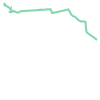

In [ ]:
wkt.loads(linestring_wkt)

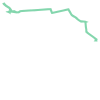

In [ ]:
wkt.loads(route_wkt)

In [ ]:
from geojson import dump

In [ ]:
geometry_matched = geojson.Feature(geometry=wkt.loads(linestring_wkt), properties={})

In [ ]:
with open('geometry_matched.geojson', 'w') as f:
   dump(geometry_matched, f)

In [ ]:
geometry_original = geojson.Feature(geometry=wkt.loads(route_wkt), properties={})

In [ ]:
with open('geometry_original.geojson', 'w') as f:
   dump(geometry_original, f)

you can download the files [geometry_matched.geojson](https://github.com/napo/geospatial_course_unitn/blob/master/data/geotemporaldata/geometry_matched.geojson) and [geometry_original.geojson](https://github.com/napo/geospatial_course_unitn/blob/master/data/geotemporaldata/geometry_original.geojson)

or simple compare [here](http://umap.openstreetmap.fr/en/map/map-matching_681846#15/45.1812/11.0681)

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/compare_map_matching.jpg)